# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2023

## Homework 10
Due Wednesday, April 12

In [1]:
using PyPlot   # Packages needed

### Description

In this homework, you will make some extensions to the `MyPoly` type in the lecture notes.

Remember to write your functions in the style of generic programming, as discussed in the
lecture notes. That is, they should correctly handle all types of coefficient vectors,
including rational and complex numbers. This is almost automatic, but sometimes the
function `eltype` is useful to ensure the right type.

First, we define the relevant functions below, with some simplifications (in particular
we remove the `var` field and assume that the independent variable is $x$).

In [2]:
struct MyPoly
    c
end

function degree(p::MyPoly)
    ix1 = findfirst(p.c .!= 0)
    if ix1 == nothing
        return 0
    else
        return length(p.c) - ix1
    end
end

function Base.show(io::IO, p::MyPoly)
    d = degree(p)
    print(io, "MyPoly(")
    for k = d:-1:0
        coeff = p.c[end-k]
        if coeff == 0 && d > 0
            continue
        end
        if k < d
            if isa(coeff, Real)
                if coeff > 0
                    print(io, " + ")
                else
                    print(io, " - ")
                end
                coeff = abs(coeff)
            else
                print(io, " + ")
            end
        end
        if isa(coeff, Real)
            print(io, coeff)
        else
            print(io, "($coeff)")
        end
        if k == 0
            continue
        end
        print(io, "⋅x")
        if k > 1
            print(io, "^", k)
        end
    end
    print(io, ")")
end

function (p::MyPoly)(x)
    d = degree(p)
    v = p.c[end-d]
    for cc = p.c[end-d+1:end]
        v = v*x + cc
    end
    return v
end

function PyPlot.plot(p::MyPoly, xlim=[-2,2])
    xx = collect(range(xlim[1], xlim[2], length=100))
    plot(xx, p.(xx))
    xlabel("x")
end

function Base.:+(p1::MyPoly, p2::MyPoly)
    d1 = length(p1.c)
    d2 = length(p2.c)
    d = max(d1,d2)
    c = [fill(0, d-d1); p1.c] + [fill(0, d-d2); p2.c]
    return MyPoly(c)
end

function Base.:-(p1::MyPoly, p2::MyPoly)
    return p1 + MyPoly(-p2.c)
end

function Base.:*(a, p::MyPoly)
    newp = deepcopy(p)
    newp.c .*= a
    return newp
end

function Base.:*(p::MyPoly, a)
    return a*p
end

### Problem 1(a)

Implement multiplication of two polynomials by overloading the `*` operator.

Test your function using the code below.

In [41]:
function Base.:*(p1::MyPoly, p2::MyPoly)
    d1 = degree(p1)
    d2 = degree(p2)
    maxd = d1 + d2
    c = fill(eltype(p1.c)(0), (maxd) + 1)
    for i = 1:length(p1.c)
        currd1 = d1 - (i - 1) 
        for j = 1:length(p2.c)
            currd2 = d2 - (j - 1)
            c[(maxd - (currd1 + currd2)) + 1] += p1.c[i] * p2.c[j]
        end
    end
    return MyPoly(c)
end

In [4]:
p1 = MyPoly([1,-2])
p2 = MyPoly([4,3,1,1])
display(p1 * p2)  # Should have integer coefficients

p1 = MyPoly([2//3, -3//7])
p2 = MyPoly([-1//2, 1//3, -1//4])
display(p1 * p2)  # Should have rational coefficients

MyPoly(4⋅x^4 - 5⋅x^3 - 5⋅x^2 - 1⋅x - 2)

MyPoly(-1//3⋅x^3 + 55//126⋅x^2 - 13//42⋅x + 3//28)

### Problem 1(b)

Implement a new constructor for the `MyPoly` type, which
creates a polynomial from a given vector of roots (and with leading term 1).
That is, for a vector $r$ with $d$ roots, we define the degree $d$ polynomial

$$
p(x) = \prod_{k=1}^d (x - r_k)
$$

To make sure we can still use the old syntax of initializing by the coefficients `c`,
overload `MyPoly` with a parameter named `roots`:

```julia
function MyPoly(; roots)
    # Implement function here
end
```

Test your function using the code below.

In [5]:
function MyPoly(; roots)
    rootp = [MyPoly([1, -i]) for i in roots]
    currp = rootp[1]
    for i = 2:length(rootp)
        currp *= rootp[i]
    end
    return currp
end

MyPoly

In [6]:
p = MyPoly(roots=[-3,-2,0,1,1,4])
display(p)  # Should have integer coefficients

p = MyPoly(roots=[-7//3,-2//1,0,1//2,1//2,3//2])
display(p)  # Should have rational coefficients

MyPoly(1⋅x^6 - 1⋅x^5 - 15⋅x^4 + 5⋅x^3 + 34⋅x^2 - 24⋅x)

MyPoly(1//1⋅x^6 + 11//6⋅x^5 - 53//12⋅x^4 - 107//24⋅x^3 + 157//24⋅x^2 - 7//4⋅x)

### Problem 1(c)

Implement a function `differentiate` which returns the derivative of a polynomial.

Test your function using the code below.

In [7]:
function differentiate(p::MyPoly)
    d = degree(p)
    rep = MyPoly(fill(eltype(p.c)(0), d))
    for i = 1:(length(p.c)-1)
        currd = d - (i - 1) 
        rep.c[(d - currd) + 1] = p.c[i] * currd
    end
    return rep
end

differentiate (generic function with 1 method)

In [8]:
differentiate(p)

MyPoly(6//1⋅x^5 + 55//6⋅x^4 - 53//3⋅x^3 - 107//8⋅x^2 + 157//12⋅x - 7//4)

### Problem 1(d)

Implement a function `integrate` which returns the (indefinite) integral of a polynomial, with
the constant term = 0.

Test your function using the code below.

In [9]:
function integrate(p::MyPoly)
    d = degree(p)
    rep = MyPoly(fill(0//1, d + 2))
    for i = 1:length(p.c)
        currd = d - (i - 1) 
        rep.c[(d - currd) + 1] = p.c[i] // (currd + 1)
    end
    return rep
end

integrate (generic function with 1 method)

In [10]:
p = MyPoly(roots=[-3,-2,0,1,1,4])
display(p)
integrate(p)

MyPoly(1⋅x^6 - 1⋅x^5 - 15⋅x^4 + 5⋅x^3 + 34⋅x^2 - 24⋅x)

MyPoly(1//7⋅x^7 - 1//6⋅x^6 - 3//1⋅x^5 + 5//4⋅x^4 + 34//3⋅x^3 - 12//1⋅x^2)

### Problem 2

In this problem you will use the polynomial type to compute Lagrange polynomials
for a set of nodes, and compute so-called elemental matrices that appear in the finite
element discretization of PDEs.

#### Problem 2(a)

Implement a function `LagrangePolynomials(s)` where `s` is a vector of $n$ numbers,
which returns a vector of $n$ polynomials $L_k(x)$, $k=1,\ldots,n$, of degree $d=n-1$
such that

$$
L_k(s_j) = \delta_{kj} =
\begin{cases}
1 & \text{if }k=j,  \\
0 & \text{otherwise.}
\end{cases}
$$

Hint: Note that a polynomial $L_k(x)$ is zero at the $n-1$ points $s_j$, $j\ne k$.
Use the `roots` constructor of `MyPoly` to create a polynomial with these roots,
then evaluate it and scale to make $L_k(s_k)=1$.

Test your function using the code below.

In [39]:
function LagrangePolynomials(s)
    n = length(s)
    d = n - 1
    L = Vector{MyPoly}(undef, n)
    for k in 1:n
        f(x) = x^(k-1)
        l_kj = []
        for j in 1:n
            x_j = s[j]
            currp = MyPoly([s[i] for i = 1:n if i != j])
            currp *= 
            push!(l_kj, currp)
        end
        l_k = l_kj[1]
        for i in 2:length(l_kj)
            l_k += l_kj[i]
        end
        L[k] = l_k
    end
    return L
end

LagrangePolynomials (generic function with 1 method)

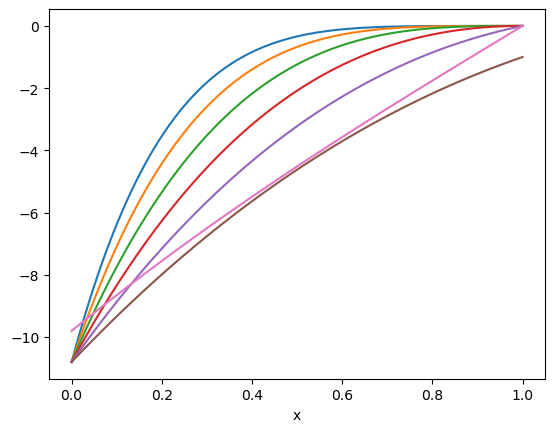

In [40]:
Ls = LagrangePolynomials((0:6) / 6)
plot.(Ls, Ref([0,1]));

### Problem 2(b)

In the finite element method (FEM), so-called mass matrices $M$ and stiffness matrices $K$
are defined as follows:

$$
\begin{align*}
M_{ij} &= \int_0^1 L_i(x) L_j(x)\,dx,\qquad i,j=1,\ldots,n \\
K_{ij} &= \int_0^1 \frac{dL_i}{dx} \frac{dL_j}{dx}\,dx,\qquad i,j=1,\ldots,n
\end{align*}
$$

Write two functions `mkM(Ls)` and `mkK(Ls)` which computes and returns these matrices,
for a given vector `Ls` of Lagrange polynomials.

Test your function using the code below. Note that in this case, the `s` vector is *rational*
and all your outputs should also be rational.

In [46]:
function mkM(Ls)
    M = Number.(zeros(length(Ls), length(Ls)))
    for i = 1:length(Ls)
        for j = 1:length(Ls)
            l = integrate(Ls[i] * Ls[j])
            M[i][j] = Number(l(1) - l(0))
        end
    end
    return M
end

function mkK(Ls)
    M = Number.(zeros(length(Ls), length(Ls)))
    for i = 1:length(Ls)
        for j = 1:length(Ls)
            dli = differentiate(Ls[i])
            dlj = differentiate(Ls[j])
            l = integrate(dli * dlj)
            M[i][j] = Number(l(1) - l(0))
        end
    end
    return M
end

mkK (generic function with 1 method)

In [47]:
d = 4
Ls = LagrangePolynomials((0:d) // d)
M = mkM(Ls)
K = mkK(Ls)
display(Ls)
display(M)
display(K)

LoadError: MethodError: no method matching setindex!(::Float64, ::Rational{Int64}, ::Int64)